In theory, there's two steps in determining the temperature of the PT100:

  1. Measure resistance
  2. Solve quadratic PT-100 equation for temperature

Both have underlying errors. Some of those have to be modeled in order to obtain temperatures that are accurate enough. These are:

  1. In resistance measurement
    1. Reference resistance (R1 in schematic) error
    2. Voltage reference offset (models 5V reference offset as well)
    3. Voltage measurement offset (0V not measured as 0)
  2. In calculating temperature from resistance
    1. PT100 not exaclty 100 ohms at 0°C
    2. Constants of resistance polynominal have errors

In [22]:
from scipy.optimize import curve_fit
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

eps = np.finfo(float).eps

In [23]:
A = 3.9083e-3
B = -5.775e-7

term1 = (A/B/2)*(A/B/2)
term2 = (1-96/100)/B
print(term1, '   ', term2)

11450166.893424036     -69264.06926406933


In [24]:
# PT100 formula: R = 100*(1+A*T+B*T²)
#   with A = 3.9083e-3
#   B = -5.775e-7

PT_A=3.9083e-3
PT_B=-5.775e-7

# adc_vals is an array of adc values
# returns array of temperatures
def temp_from_adc(adc_vals, R_ref=1e3, V_ref=1.1,
                  PT_R=100, V_ref_0=0):
    adc_max=1023
    temperatures = []
    for adc_val in adc_vals:
        V_measured = V_ref*adc_val/adc_max
        R_measured = R_ref/(5/V_measured-1)
        sqrt_arg = (PT_A/PT_B/2)*(PT_A/PT_B/2)-(1-R_measured/PT_R)/PT_B
        if sqrt_arg < 0:
            print("temp_from_adc: Negative sqrt, returning!")
            print("Called with")
            print(" adc_val =", adc_val)
            print(" R_ref =", R_ref)
            print(" V_ref =", V_ref)
            print(" V_ref_0 =", V_ref_0)
            print(" PT_R =", PT_R)
            print(" PT_A =", PT_A)
            print(" PT_B =", PT_B)
            print(' -----------------')
            print(' adc_val =', adc_val)
            print(' R_measured =', R_measured)
            print(' term1 =', (PT_A/PT_B/2)*(PT_A/PT_B/2))
            print(' term2 =', (1-R_measured/PT_R)/PT_B)

            temperatures.append(np.inf) # Really bad value, should optimize away from this
        else:
            temperatures.append(-(PT_A/PT_B/2)-np.sqrt(sqrt_arg))
    return(temperatures)

In [25]:
# Measurements to determine best fit parameters
# for temperature calculation:
adc_vals = np.array([545, 572, 562, 466, 493, 503, 535, 514, 501])

measured_temps = np.array([72, 90, 82, 18, 34, 42, 63, 49, 40])

In [26]:
# Determine parameter best fit:

p_initial = [1e3,       # R_ref
             1.1,       # V_ref
             100,       # PT_R
             0         # V_ref_0
            ]

# Reasonable bounds:
bounds_low =  [ 950, 1, 90, 0]
bounds_high = [1050, 1.2, 110, eps]

p_fit, _ = curve_fit(temp_from_adc, xdata=adc_vals,
                  ydata=measured_temps, p0=p_initial,
                  bounds=(bounds_low, bounds_high))
p_fit

array([9.99977827e+02, 1.05988651e+00, 1.00044296e+02, 1.11022302e-16])

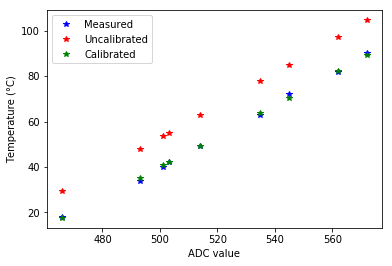

In [27]:
plt.plot(adc_vals, measured_temps, marker='*', linestyle='None', color='blue', label='Measured')
plt.plot(adc_vals, temp_from_adc(adc_vals), marker='*', linestyle='None', color='red', label='Uncalibrated')
plt.plot(adc_vals, temp_from_adc(adc_vals, *p_fit), marker='*', linestyle='None', color='green', label='Calibrated')

plt.xlabel('ADC value')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

Let's see how bad that error is over a bigger temperature range...

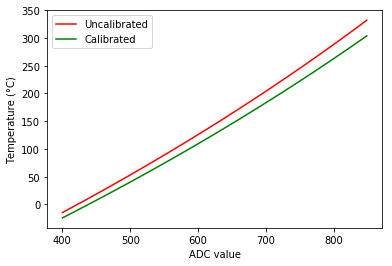

In [28]:
adc_vals = np.arange(400, 850)
plt.plot(adc_vals, temp_from_adc(adc_vals), color='red', label='Uncalibrated')
plt.plot(adc_vals, temp_from_adc(adc_vals, *p_fit), color='green', label='Calibrated')

plt.xlabel('ADC value')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

**That looks pretty bad! At least the voltage reference error has to be taken into account!**

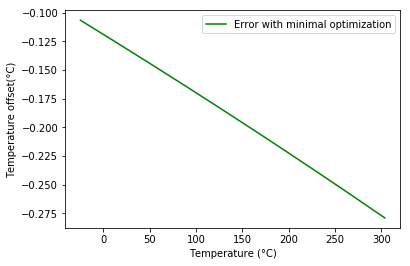

In [31]:
fully_optim = np.array(temp_from_adc(adc_vals, *p_fit))
# Leave only V_ref:
fit_minimal = p_initial
fit_minimal[1] = p_fit[1]
partly_optim = np.array(temp_from_adc(adc_vals, *fit_minimal))

plt.plot(fully_optim, fully_optim-partly_optim, color='green', label='Error with minimal optimization')

plt.xlabel('Temperature (°C)')
plt.ylabel('Temperature offset(°C)')
plt.legend()
plt.show()

**So taking only the voltage reference offset into account is accurate enough.**